In [1]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
import re
import gc
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fullmodel = T5ForConditionalGeneration.from_pretrained("/data/franco/datasets/prot_embedding_weights/prottrans_t5_xl_u50/").to(device)

#fullmodel.full() if str(device)=='cpu' else fullmodel.half()

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('/data/franco/datasets/prot_embedding_weights/prottrans_t5_xl_u50', do_lower_case=False, legacy=False)


In [16]:
def sequence_masker(seq, i, j, same_extra_token=False):
    masked_sequence_list = seq.split()
    token_num = 0
    if j<=i:
        print(f"index j={j} must be greater than i={i}")
        raise
    for x in range(i, j):
        if j > len(seq):
            break
        masked_sequence_list[x] = f"<extra_id_{token_num}>"
        if not same_extra_token:
            token_num += 1
    return " ".join(masked_sequence_list)

test = "P R O T E I N A"


In [23]:
import random

testsequence = "PROTEINSEQUENCE"
#testsequence = "CQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEED"
input_test = [" ".join(list(re.sub(r"[UZOB]", "X", testsequence)))]
print(input_test)

masked_test = [sequence_masker(input_test[0], 4, 5)]
print(masked_test)

ids1 = tokenizer.batch_encode_plus(input_test, add_special_tokens=True, padding="longest")
# print(ids1)
ids2 = tokenizer.batch_encode_plus(masked_test, add_special_tokens=True, padding="longest")
# print(ids2)

# print(tokenizer(input_test[0]))
# print(tokenizer(masked_test[0]))

['P R X T E I N S E Q X E N C E']
['P R X T <extra_id_0> I N S E Q X E N C E']


In [24]:
true_ids  = torch.tensor(ids1['input_ids']).to(device)
input_ids = torch.tensor(ids2['input_ids']).to(device)
attention_mask = torch.tensor(ids2['attention_mask']).to(device)

#embfull = fullmodel(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)

In [80]:
with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=true_ids)
    loss  = emb.loss.cpu()
    print(loss)

tensor(0.1585)


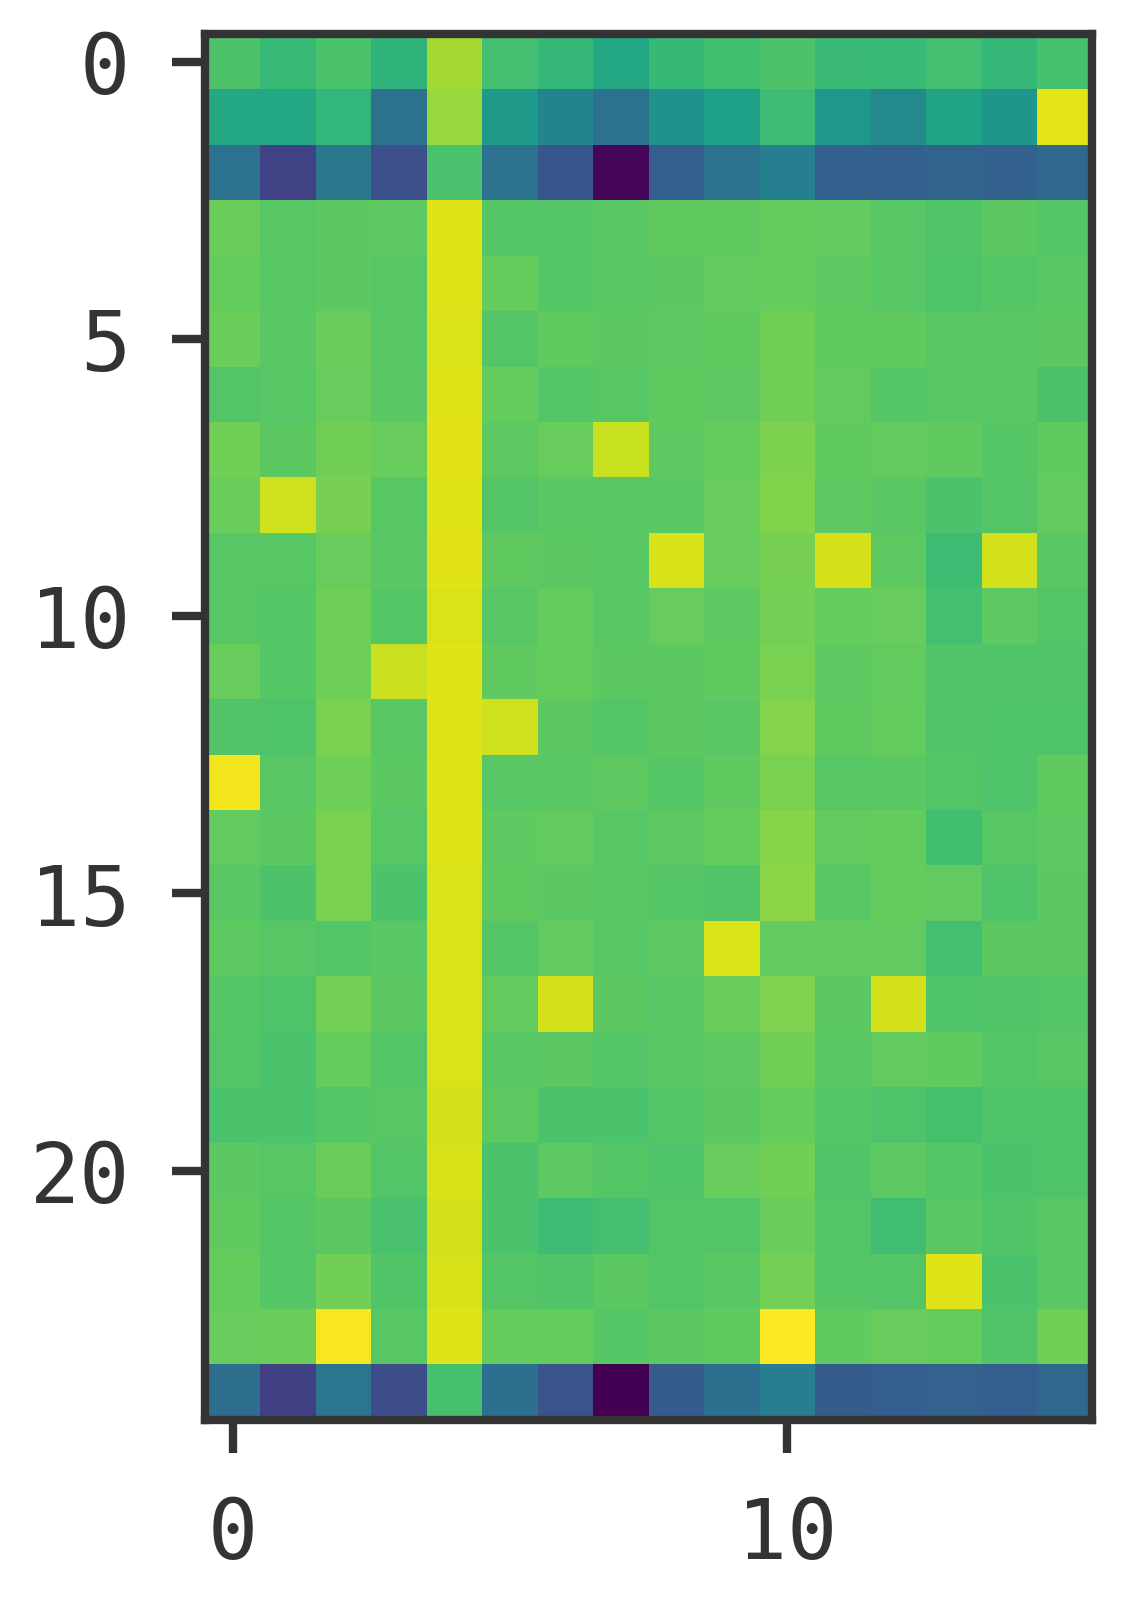

In [81]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# move tensor to cpu
logits_cpu = emb.logits[0,:,0:25].T.cpu()
ax.imshow(np.array(logits_cpu))
#ax.imshow(np.array(emb.logits[0,:,0:25].T))
plt.show()

In [34]:
fastpred = tokenizer.decode(torch.tensor(emb.logits[:,:-1,:].numpy().argmax(-1)[0]), skip_special_tokens=False).replace("<"," <").replace(">","> ")
fastpred

'P R X T S I N S E Q X E N C E'

In [38]:
print(masked_test)
print(input_ids)
with torch.no_grad():
    outputs = fullmodel.generate(input_ids=input_ids, max_length=len(masked_test[0].split())+2, min_length=len(masked_test[0].split()))
outputs
# tokenizer.get_vocab()

['P R X T <extra_id_0> I N S E Q X E N C E']
tensor([[ 13,   8,  23,  11, 127,  12,  17,   7,   9,  16,  23,   9,  17,  22,
           9,   1]])


tensor([[ 0, 13,  8, 23, 11,  7, 12, 17,  7,  9, 16, 23,  9, 17, 22,  9,  1]])

In [39]:
tokenizer.decode(outputs[0])

'<pad> P R X T S I N S E Q X E N C E</s>'

In [92]:
# from transformers import T5Config

# generation_config = TConfig(top_k=5, 
#                                      max_length=len(masked_test[0].split())+2, 
#                                      min_length=len(masked_test[0].split()))

#                                  min_length=len(masked_test[0].split()),
with torch.no_grad():
    outputs = fullmodel.generate(input_ids=input_ids, top_k=5,
                                 max_length=len(masked_test[0].split())+2, 
                                 return_dict_in_generate=True,
                                 output_scores=True)
outputs

GreedySearchEncoderDecoderOutput(sequences=tensor([[ 0, 13,  8, 23, 11,  7, 12, 17,  7,  9, 16, 23,  9, 17, 22,  9,  1]]), scores=(tensor([[-25.4961, -38.5075, -63.9058, -19.5280, -21.0391, -19.3930, -24.2966,
         -18.1446, -19.9344, -23.6502, -23.2703, -20.4421, -24.6700,   2.9804,
         -21.1798, -23.0854, -22.0552, -23.8281, -24.3745, -26.1499, -22.7438,
         -21.5749, -20.9961, -20.4728, -64.9148, -64.4154, -64.5094, -64.3286,
         -63.4083, -64.2757, -63.8107, -64.2032, -64.0822, -64.9755, -64.5062,
         -64.7453, -64.8627, -64.2806, -64.3073, -65.0233, -63.5916, -64.7990,
         -64.7718, -64.4511, -63.7952, -64.5799, -64.1521, -63.4750, -63.6353,
         -64.1532, -64.3379, -64.2673, -64.0193, -63.5146, -64.8273, -64.4914,
         -63.0924, -63.6982, -64.7265, -64.2597, -64.2585, -63.9862, -64.5949,
         -64.2420, -63.2014, -64.1930, -63.1778, -63.8857, -63.8981, -65.4407,
         -64.8064, -64.6660, -64.7400, -64.2947, -63.9397, -63.3271, -64.2944,


In [97]:
tokenizer.decode(outputs.sequences[0])

'<pad> P R X T S I N S E Q X E N C E</s>'

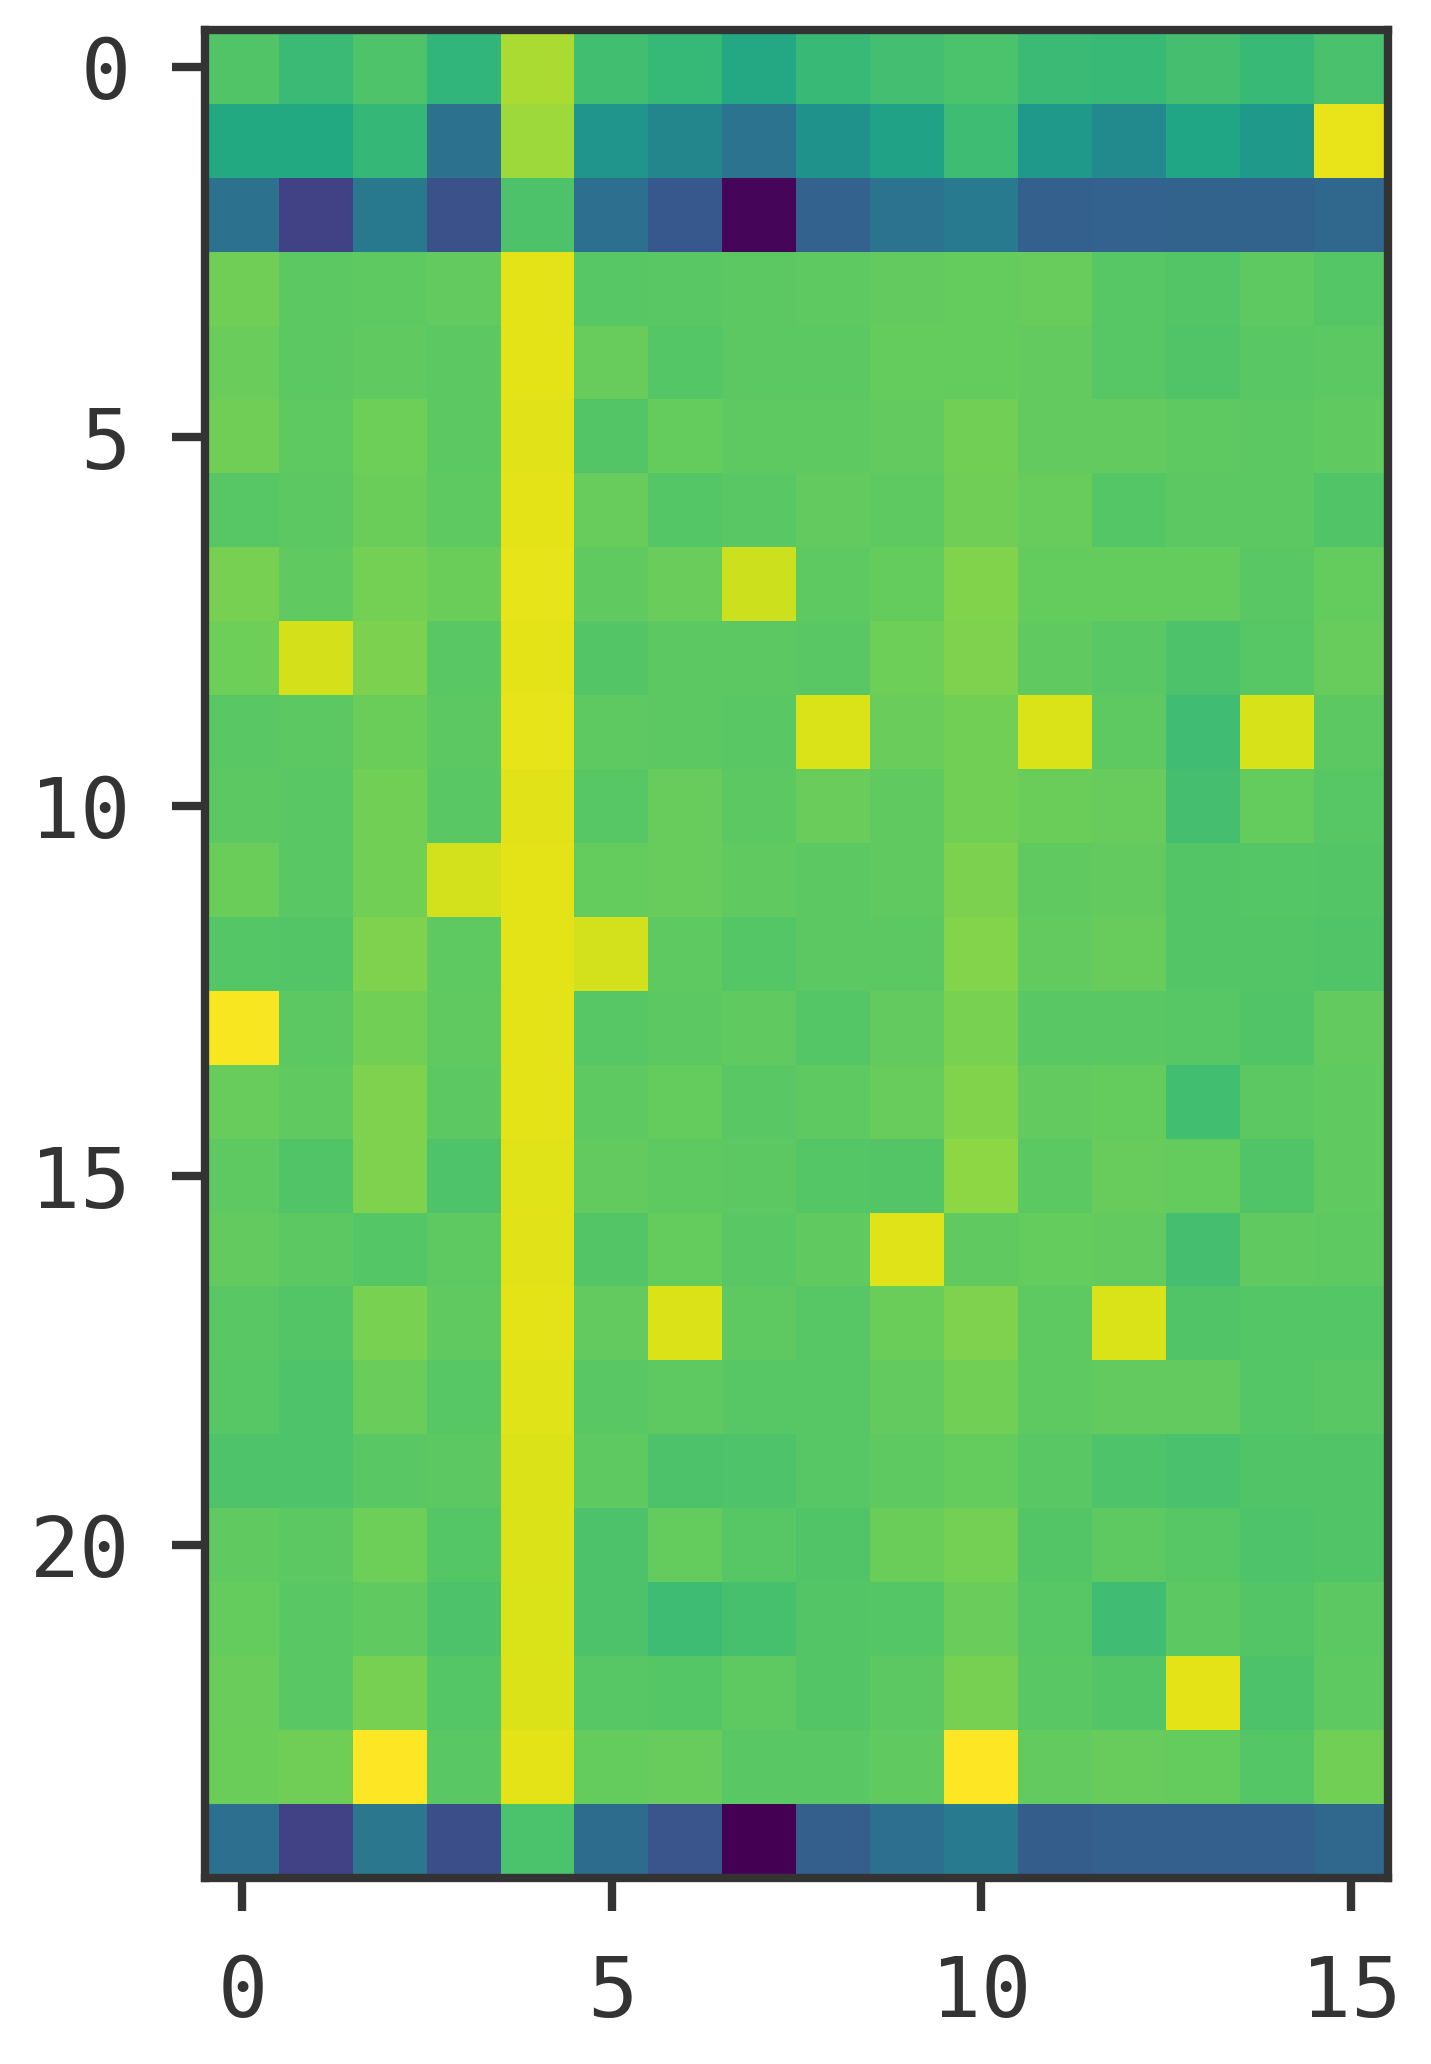

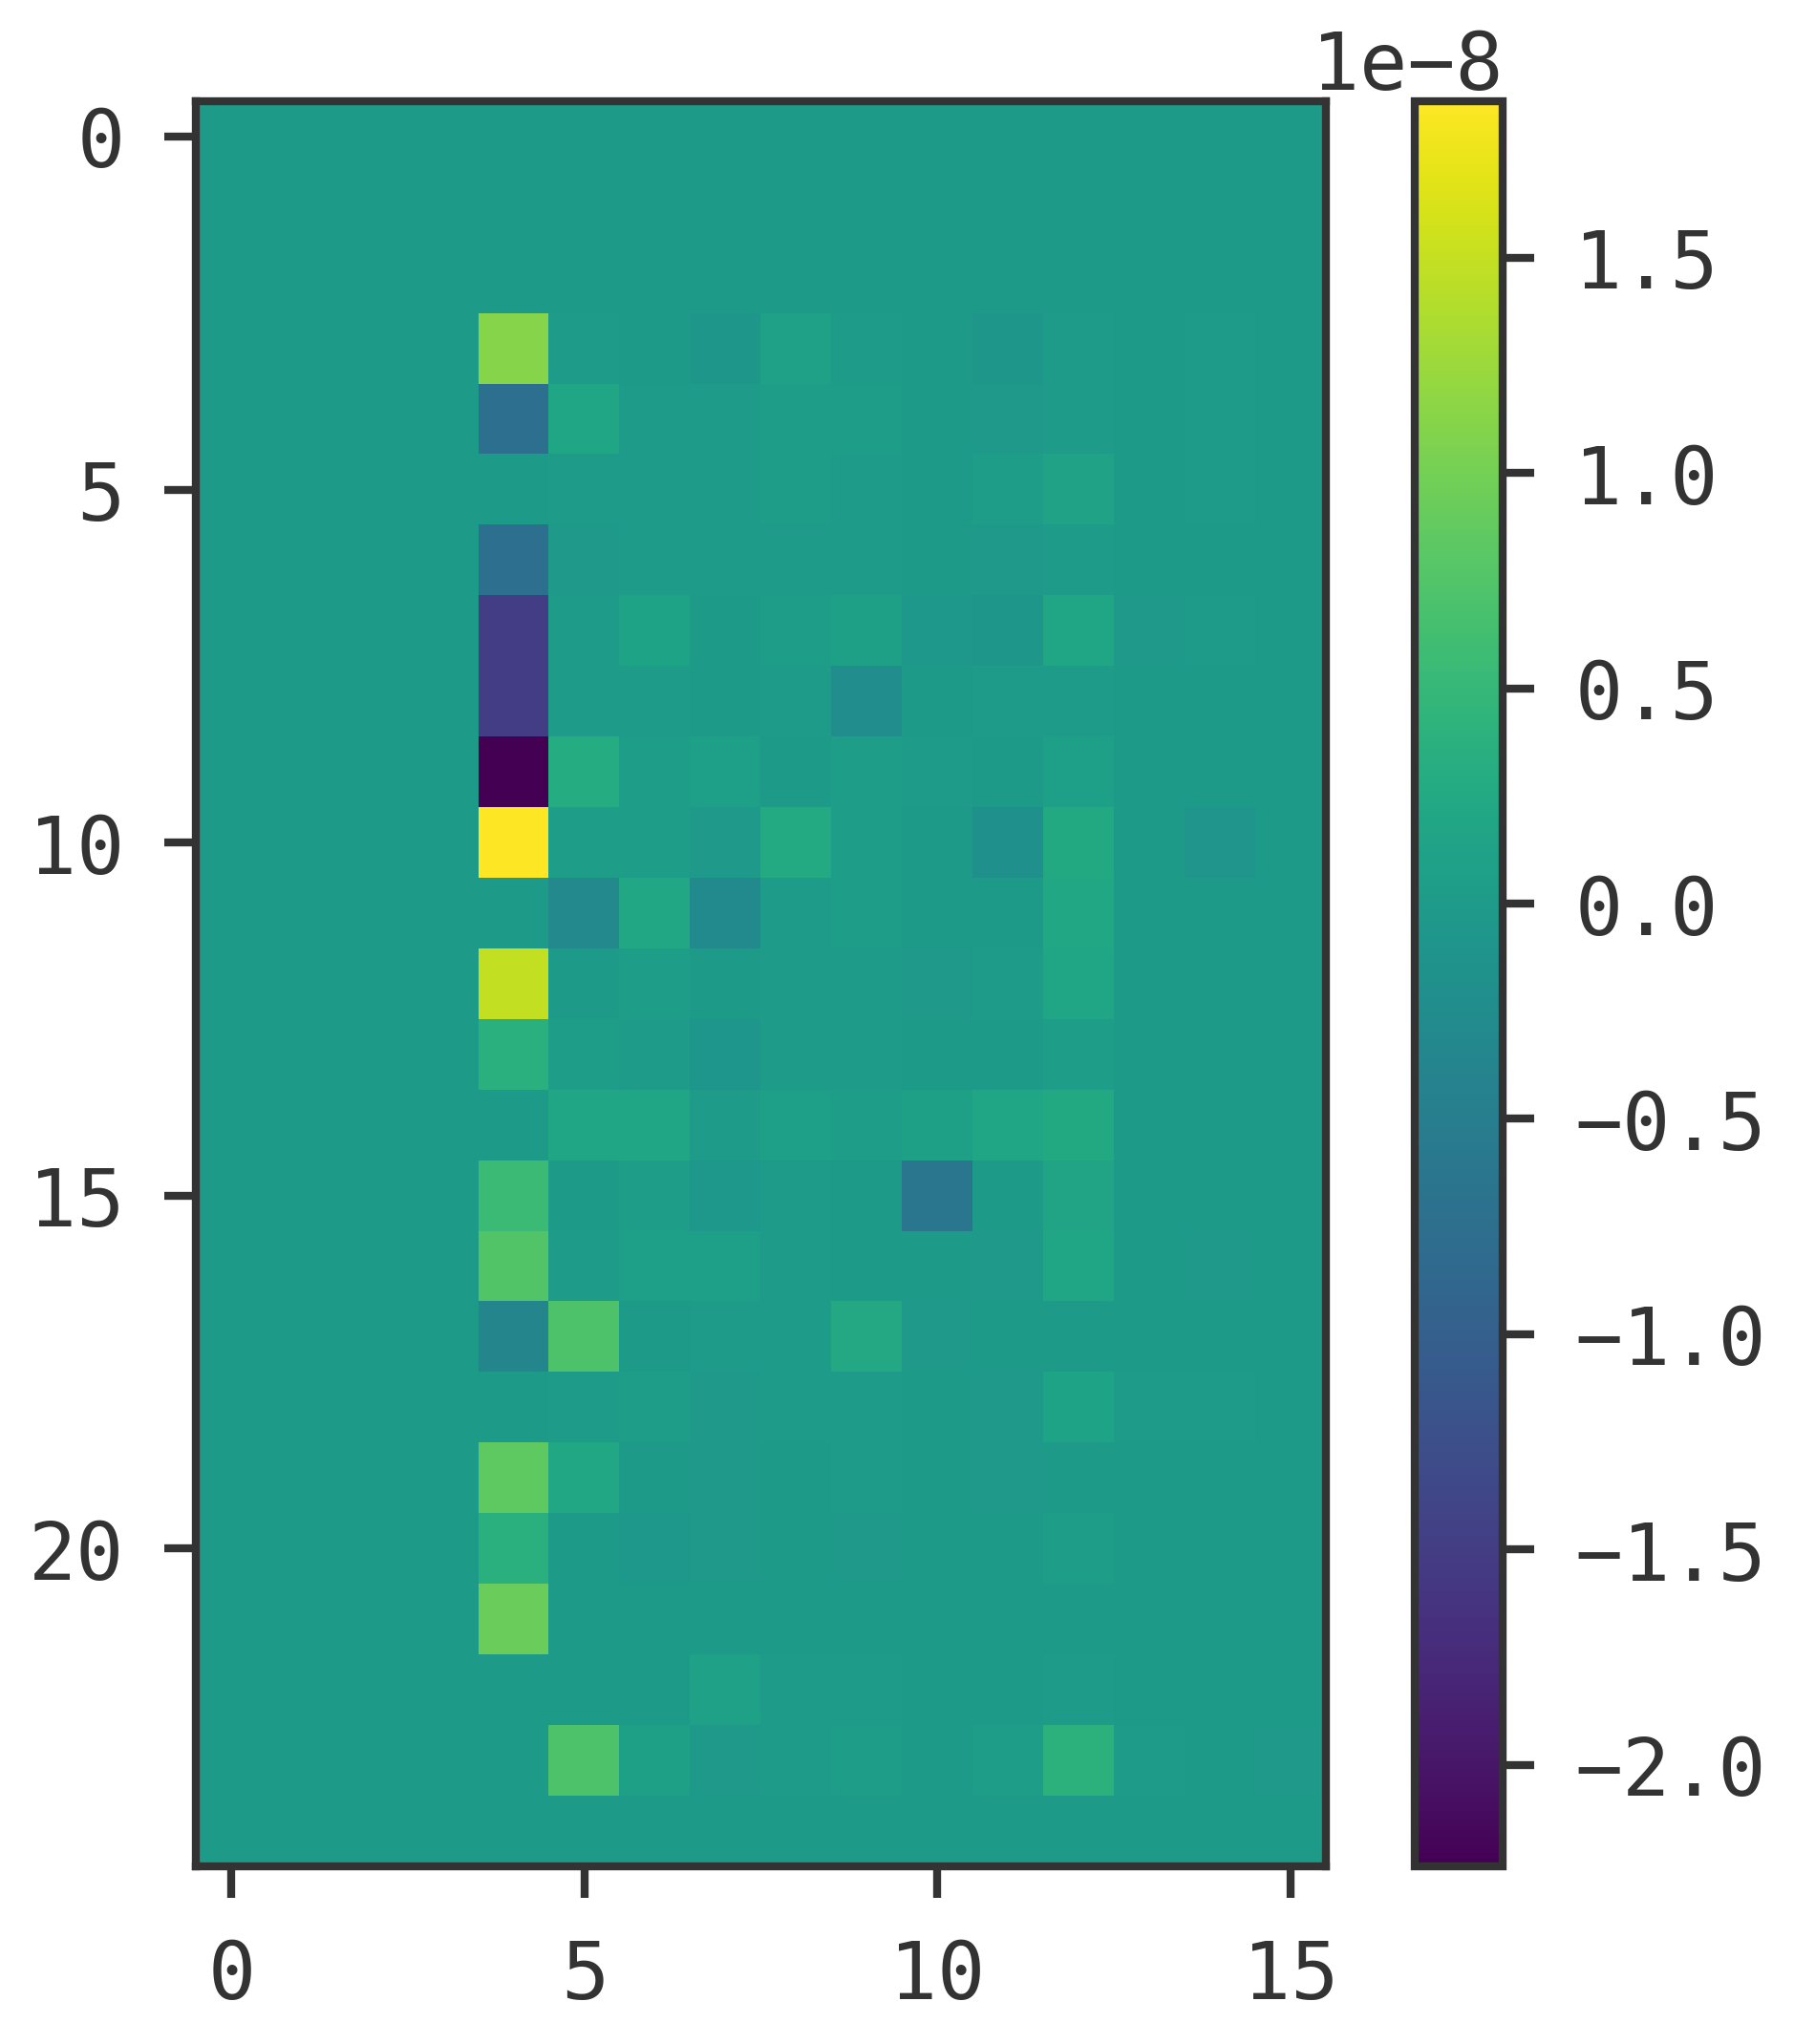

In [218]:
genlogits = np.vstack(outputs.scores)[:,0:25].T
plt.imshow(genlogits)
plt.show()

diff = logits_cpu.softmax(dim=0) - torch.tensor(genlogits).softmax(dim=0)
plt.imshow(diff)
plt.colorbar()
plt.show()

In [227]:
torch.min(diff)

tensor(-2.2352e-08)

In [101]:
fullmodel.config

T5Config {
  "_name_or_path": "/data/franco/datasets/prot_embedding_weights/prottrans_t5_xl_u50/",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 32,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.21.1",
  "use_cache": true,
  "vocab_size": 128
}

In [182]:
print(fullmodel.num_parameters())

# https://jimmy-shen.medium.com/transformer-number-of-parameters-estimation-92a80021bba9
d_model = 1024
d_k = 128
h = 32
d_ff = 16384
vocab = 128
MHA = 3*d_model*d_k*h + d_model*d_model + 4*d_model
MHA1 = 4*d_model*d_k*h + 4*d_model + h
MHA0 = 4*(d_model*d_model + d_model)

LayerNorm = 2*d_model
FF = 2*d_ff*d_model + d_ff + d_model

Encoder = 24*(MHA + 2*LayerNorm + FF + h*h)
Decoder = 24*(2*MHA + 3*LayerNorm + FF + h*h)
Linear = d_model*vocab + vocab

total = Encoder+Decoder+Linear
diff = Encoder+Decoder+Linear-fullmodel.num_parameters()
print(f"{total}")


print(Encoder)
print(Decoder)
print(Linear)
print(diff)
diff/1024

2818830336
2593636480
1133101056
1460404224
131200
-225193856


-219915.875

In [253]:
loss = torch.nn.CrossEntropyLoss()
input = emb.logits[0]
target = true_ids[0]
output = loss(input, target)
print(output)

tensor(0.1585)


In [252]:
emb.logits[0].shape

torch.Size([16, 128])

In [588]:
#### My own cross-entropy loss test function
#### it's very close to the one calculated by torch, probably decimal issues

inp = torch.tensor([[-50,-50,-1,-40],[-2.,-20.2,-32,-47],[-1.5,-11.1,-37,-40]])
tar = torch.tensor([2,0,0])
print(inp.shape, tar.shape)
loss(inp,tar)

torch.Size([3, 4]) torch.Size([3])


tensor(2.2570e-05)

In [589]:
### custom cross-entropy loss
N = 3
#isoft = inp.softmax(dim=1)
isoft = inp

acum = 0
acum2 = 0
targfreqs = tar.bincount() / tar.numel()

for i in range(N):
    tmp = (isoft[i,tar[i]].exp() / isoft[i,:].exp().sum() ).log() * targfreqs[tar[i]] 
    acum += -tmp

print(f"acum {acum}")

acum 4.5142114686314017e-05


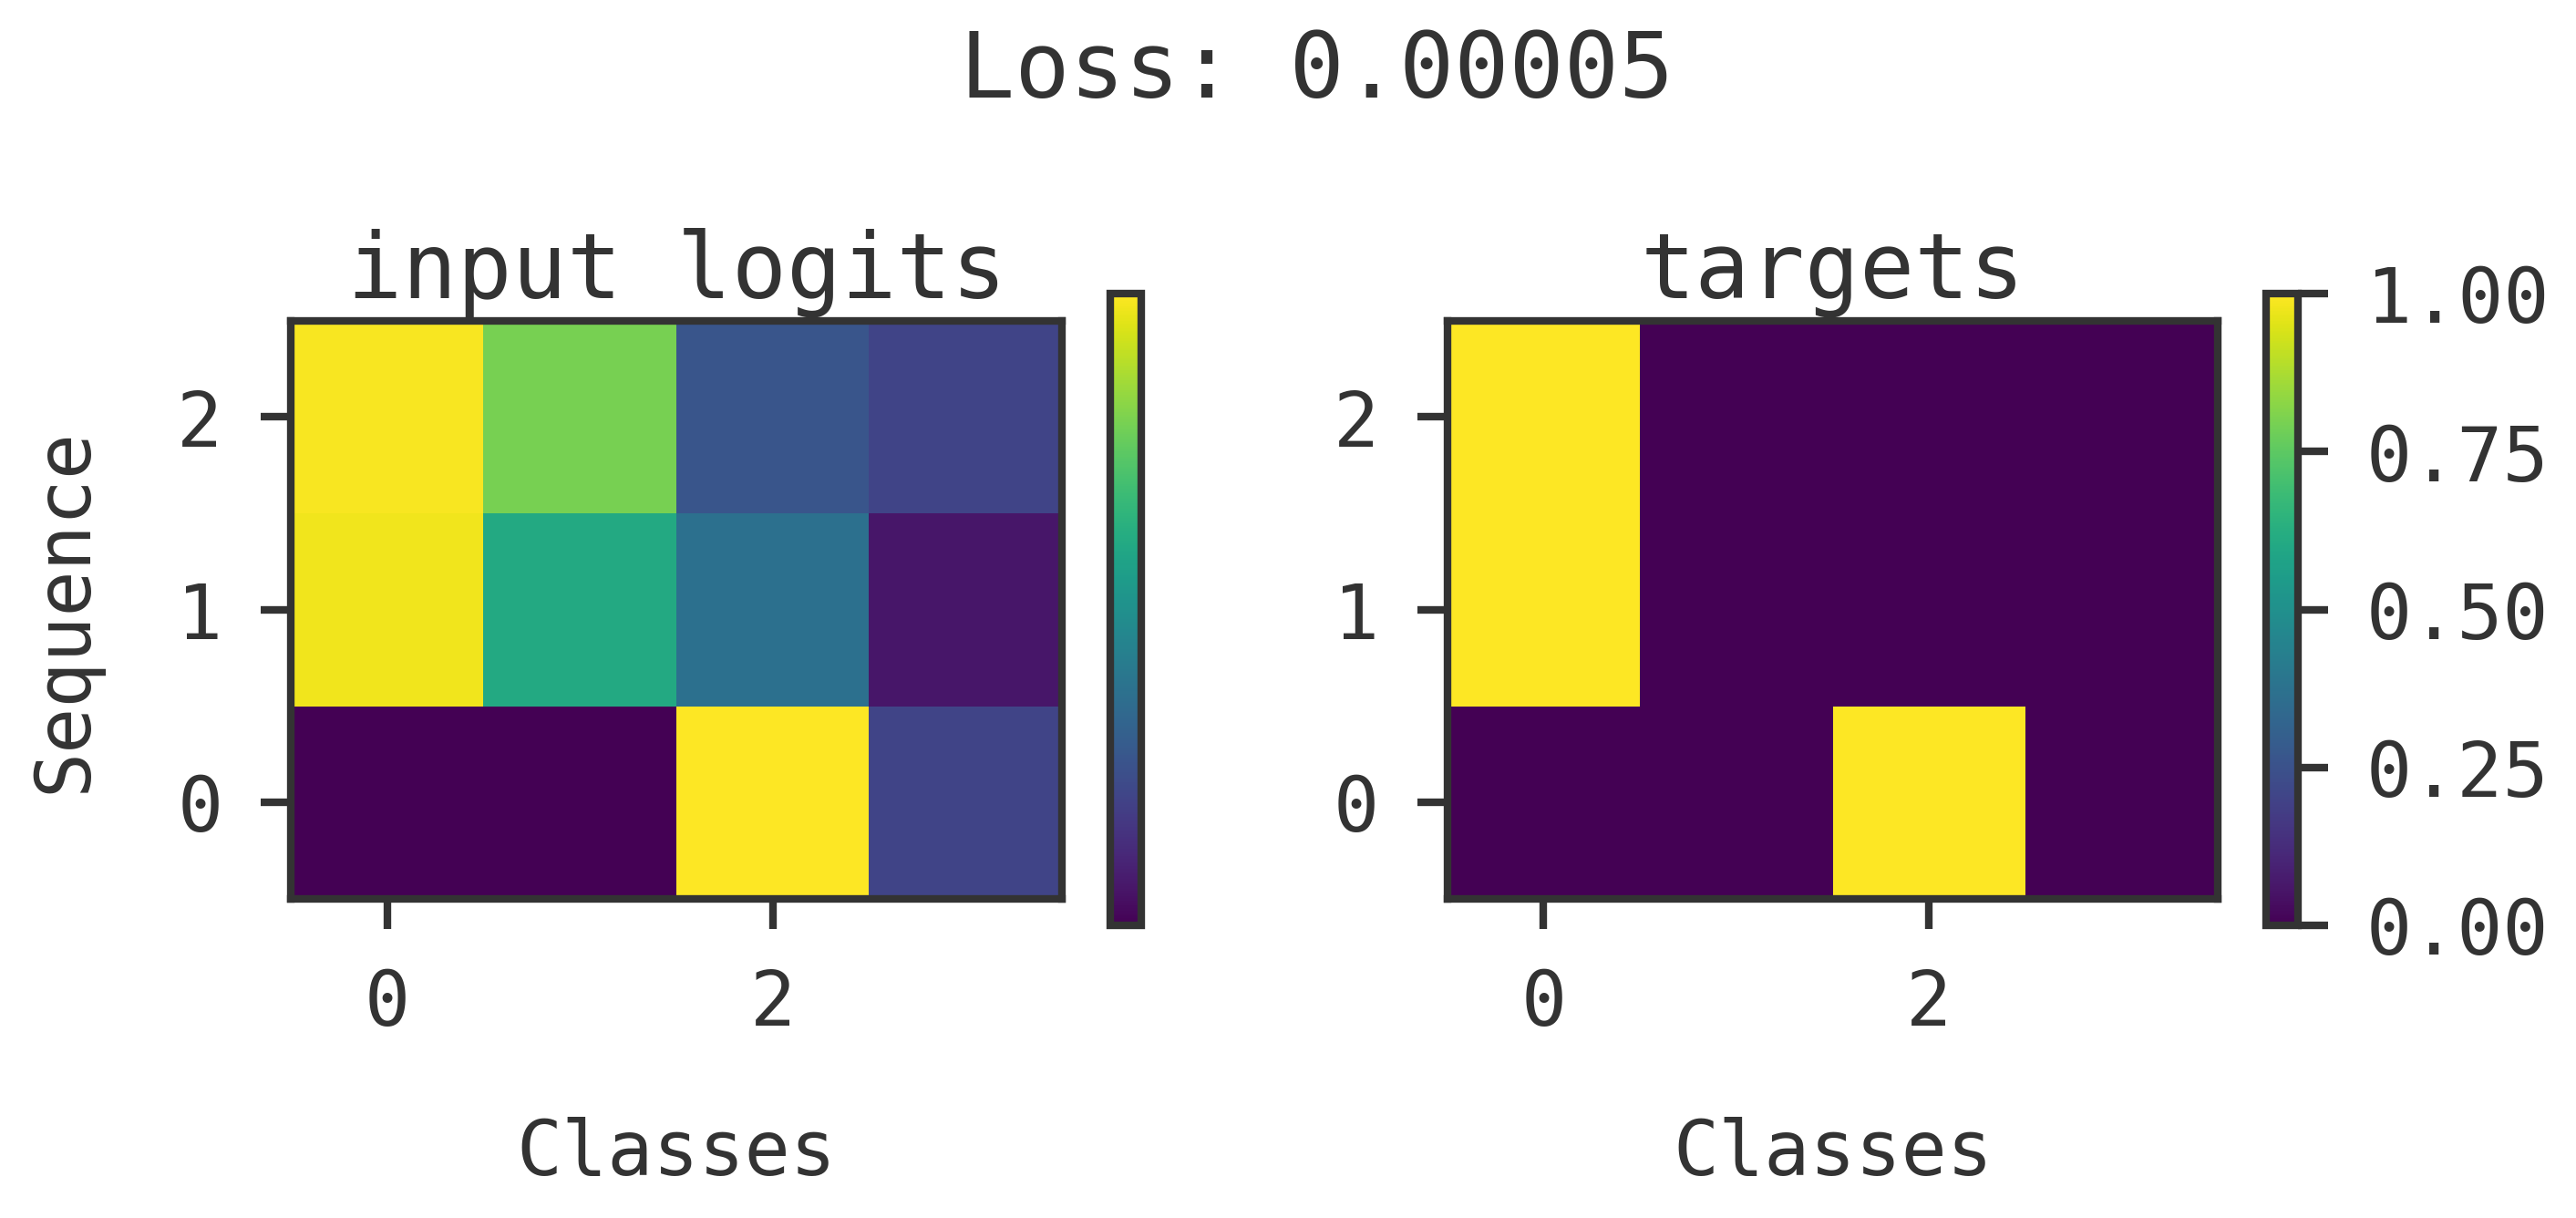

In [591]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

tarmat = np.zeros(inp.shape)
for i in range(len(tar)):
    tarmat[i,tar[i]] = 1

e1 = ax1.imshow(inp, origin='lower')
e2 = ax2.imshow(tarmat, origin='lower')

ax1.set_title("input logits")
ax2.set_title("targets")
ax1.set_ylabel("Sequence")
ax1.set_xlabel("Classes")
ax2.set_xlabel("Classes")
fig.colorbar(e1, ax=ax1, shrink=0.5, ticks=[])
fig.colorbar(e2, ax=ax2, shrink=0.5)
fig.suptitle(f"Loss: {acum:.5f}", y=0.85)

plt.show()